# Variational monte carlo simulation for 1D harmonic oscillator.

The local energy equals:  0.508312566605 
With uncertainty:  0.0168350334728


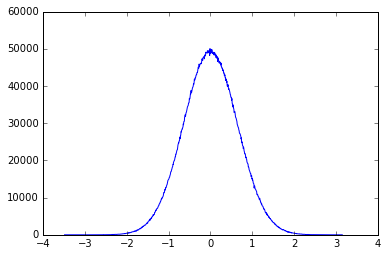

In [79]:
import numpy as np
from matplotlib import pyplot as plt
import math
%matplotlib inline
#Harmonic oscillator local energy
def ElHarm(x, a):
    return a + x * x * (0.5 - 2 * a ** 2)
            
def updateWalkers(w, nWalk, a):
    wNew = np.random.normal(0,math.sqrt(1 / 2 / a), nWalk)
    ratio = np.exp(-2 * a * ((w+wNew) ** 2 - w ** 2)) 
    u = np.random.uniform(size=(nWalk))
    w += (u < ratio) * wNew
            
nWalk = 400
nStep = 30000
a = 0.6
nEquilibriate = 4000

r = np.zeros(nWalk * nStep)
w = np.random.uniform(-math.sqrt(1 / 2 / a),math.sqrt(1 / 2 / a), nWalk) #initiate walkers in uniform distr
    
for i in range(0, nEquilibriate):
    updateWalkers(w, nWalk, a)
    
for i in range(0, nStep):
    updateWalkers(w, nWalk, a)
    r[i * nWalk : (i + 1) * nWalk] = w
    
hist, bin_edges = np.histogram(r,1000)
        
        
        
plt.plot(np.linspace(min(bin_edges),max(bin_edges), len(hist)), hist)


print("The local energy equals: ", np.mean(ElHarm(r, a)), "\nWith uncertainty: ", np.var(ElHarm(r, a)))

# Variational MonteCarlo code for Hydrogen Atom

The local energy equals:  -0.494856674456 
With uncertainty:  0.0119918359487


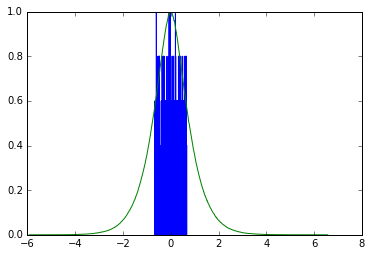

In [86]:
import numpy as np
from matplotlib import pyplot as plt
import math
%matplotlib inline
#Harmonic oscillator local energy
def ElHarm(x, a):
    return a + x * x * (0.5 - 2 * a ** 2)

#hydrogen atom local energy
def ElHydro(x, a):
    g = 1 / np.sqrt(np.sum(x ** 2, axis = 1))
    return -g - 0.5 * a * (a - 2 * g)
            
def updateWalkers(w, nWalk, a):
    d = 0.1 * np.random.normal(0,math.sqrt(1 / 2 / a), (nWalk, 3))
    ratio = np.exp( -2 * a * (np.sqrt(np.sum((w + d) ** 2, axis=1)) - np.sqrt(np.sum(w ** 2, axis=1)))) 
    u = np.random.uniform(size=(nWalk))
    w += (u < ratio)[:,None] * d
            
nWalk = 400
nStep = 30000
a = 1.1
nEquilibriate = 4000

r = np.zeros((nWalk * nStep , 3))
w = np.random.uniform(-math.sqrt(1 / 2 / a),math.sqrt(1 / 2 / a), (nWalk,3)) #initiate walkers in uniform distr
    
hist, bin_edges = np.histogram(w,1000)
plt.plot(np.linspace(min(bin_edges),max(bin_edges), len(hist)), hist / max(hist))
    
for i in range(0, nEquilibriate):
    updateWalkers(w, nWalk, a)
    
for i in range(0, nStep):
    updateWalkers(w, nWalk, a)
    r[i * nWalk : (i + 1) * nWalk, :] = w
    
hist, bin_edges = np.histogram(r,1000)
plt.plot(np.linspace(min(bin_edges),max(bin_edges), len(hist)), hist / max(hist))


print("The local energy equals: ", np.mean(ElHydro(r, a)), "\nWith uncertainty: ", np.var(ElHydro(r, a)))

# VMC for hydrogen molecule

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: RuntimeWarning: overflow encountered in exp
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: overflow encountered in add
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: overflow encountered in exp
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: overflow encountered in multiply
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: overflow encountered in exp
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: overflow encountered in exp
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: overflow encountered in add
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: RuntimeWar

The local energy equals:  nan 
With uncertainty:  nan


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


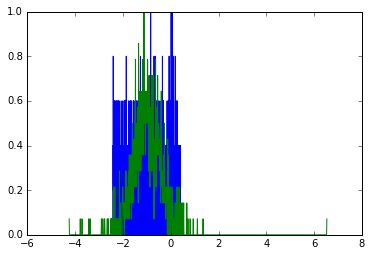

In [26]:
#NOW I HAVE CREATED THE INITIAL CONDITIONS: FOR NEXT TIME WE NEED 

import numpy as np
from matplotlib import pyplot as plt
import math
%matplotlib inline
#x is a 6dimensional vector

#hydrogen molecule local energy
def ElHydro(x, a, s, alpha, beta):
    r1 = x[:,0:3] #position of first electron
    r2 = x[:,3:6] #position of second electron
    sL = [-s / 2, 0, 0] #position of left hydrogen atom
    sR = [s / 2, 0, 0] #position of right hydrogen atom
    r1L = np.linalg.norm(r1-sL, axis = 1)
    r2L = np.linalg.norm(r2-sL, axis = 1)
    r1R = np.linalg.norm(r1-sR, axis = 1)
    r2R = np.linalg.norm(r2-sR, axis = 1)
    r12 = np.linalg.norm(r1-r2, axis = 1)
    phi1L = np.exp(-r1L / a)
    phi1R = np.exp(-r2R / a)
    phi1 = phi1R + phi1L
    phi2L = np.exp(r2L / a)
    phi2R = np.exp(r2R / a)
    phi2 = phi2R + phi2L
    
    El = -1 / a ** 2 + 1 / (a * phi1) * (phi1L / r1L + phi1R / r1R)
    El += 1 / (a * phi2) * (phi2L / r2L + phi2R / r2R)
    El -= (1 / r1L + 1 / r1R + 1 / r2L + 1 / r2R)
    El += 1 / r12
    El += sum(sum(((phi1L[:,None] * (r1 - sL) + phi1R[:,None] * (r1 - sR)) / phi1[:,None] - (phi2L[:,None] * (r2 - sL) + phi2R[:,None] * (r2 - sR)) / phi2[:,None] ) * ((r1 - r2) / (2 * a * (1 + beta * r12[:,None]) ** 2))))
    El -= ((4 * beta + 1) * r12 + 4) / (4 * (1 + beta * r12) ** 4 * r12)
    
    return El
       
def updateWalkers(w, nWalk, a, s, alpha, beta):
    d = 0.1 * np.random.normal(0,math.sqrt(1 / 2 / a), (nWalk, 6))
    ratio = calcPsi(w + d, a, s, alpha, beta) / calcPsi(w , a, s, alpha, beta) 
    u = np.random.uniform(size=(nWalk))
    w += (u < ratio)[:,None] * d
    
def calcPsi(x, a, s, alpha, beta):
    r1 = x[:,0:3] #position of first electron
    r2 = x[:,3:6] #position of second electron
    sL = [-s / 2, 0, 0] #position of left hydrogen atom
    sR = [s / 2, 0, 0] #position of right hydrogen atom
    r1L = np.linalg.norm(r1-sL, axis = 1)
    r2L = np.linalg.norm(r2-sL, axis = 1)
    r1R = np.linalg.norm(r1-sR, axis = 1)
    r2R = np.linalg.norm(r2-sR, axis = 1)
    r12 = np.linalg.norm(r1-r2, axis = 1)
    phi1L = np.exp(-r1L / a)
    phi1R = np.exp(-r2R / a)
    phi1 = phi1R + phi1L
    phi2L = np.exp(r2L / a)
    phi2R = np.exp(r2R / a)
    phi2 = phi2R + phi2L
    
    return phi1 * phi2 * np.exp(r12 / (alpha * (1 + beta * r12)))
            
nWalk = 1000
nStep = 10000
nEquilibriate = 1000

#four parameters:
alpha = 2
s = 2 #start with 2 times bohr radius of el(should be varied)
a = 1 / (2 * s) #linearized crusp condition(should be improved i think.)
beta = 0.6 #beta should be varied also (in what range??)

r = np.zeros((nWalk * nStep , 6))
w = np.zeros((nWalk, 6))
w[:,0:3] = np.random.uniform(-math.sqrt(1 / 2 / a) - s / 2,math.sqrt(1 / 2 / a) - s / 2, (nWalk,3)) #initiate walkers of first electron in uniform distr
w[:,3:6] = np.random.uniform(-math.sqrt(1 / 2 / a) + s / 2,math.sqrt(1 / 2 / a) + s / 2, (nWalk,3)) #initiate walkers of 2nd el.
    
hist, bin_edges = np.histogram(w[:,0],1000)
plt.plot(np.linspace(min(bin_edges),max(bin_edges), len(hist)), hist / max(hist))
    
for i in range(0, nEquilibriate):
    updateWalkers(w, nWalk, a, s, alpha, beta)
    
for i in range(0, nStep):
    updateWalkers(w, nWalk, a, s, alpha, beta)
    r[i * nWalk : (i + 1) * nWalk, :] = w

hist, bin_edges = np.histogram(w[:,0],1000)
plt.plot(np.linspace(min(bin_edges),max(bin_edges), len(hist)), hist / max(hist))

print("The local energy equals: ", np.mean(ElHydro(r, a, s, alpha, beta)), "\nWith uncertainty: ", np.var(ElHydro(r, a, s, alpha, beta)))

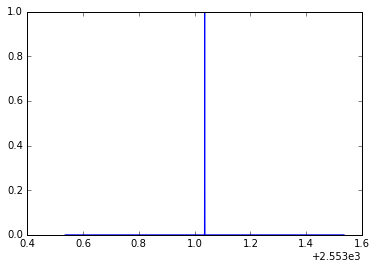

In [20]:
hist, bin_edges = np.histogram(np.linalg.norm(r[:,0:3]),1000)
plt.plot(np.linspace(min(bin_edges),max(bin_edges), len(hist)), hist / max(hist))

In [10]:
i *nWalk

90000